## Different imports and setup

In [5]:
# Standard import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [6]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf

In [7]:
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

## Set the seeds and extract the testing set

In [8]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [9]:
features_training, labels_training, features_val, labels_val, features_test, labels_test = Helpers.Load_and_split_val(
    'Data/tanh_10D_sum.txt', D=10, seed=seed, ratio_test=0.1, ratio_val=0.1)

In [10]:
features_training.shape

(80000, 10)

## Check where the radius are located on the training and testing set

In [70]:
center = np.zeros(10)
rad_training = np.linalg.norm(features_training - center, ord=2, axis=1)
rad_testing = np.linalg.norm(features_test - center, ord=2, axis=1)

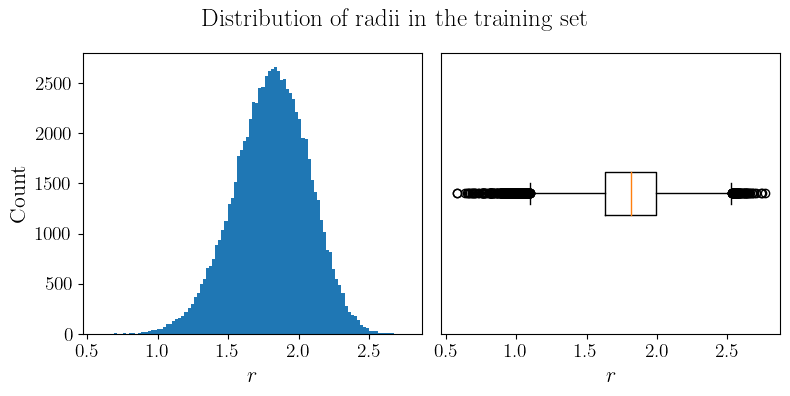

In [71]:
save = False
name = 'Figures/10D/ditribution_radii_training.pdf'

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(rad_training, bins=100)
axs[0].set(xlabel='$r$', ylabel='Count')

axs[1].boxplot(rad_training, vert=False)
axs[1].set(xlabel='$r$')
axs[1].set_yticks([])
       
fig.suptitle('Distribution of radii in the training set', size=18)
fig.tight_layout()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

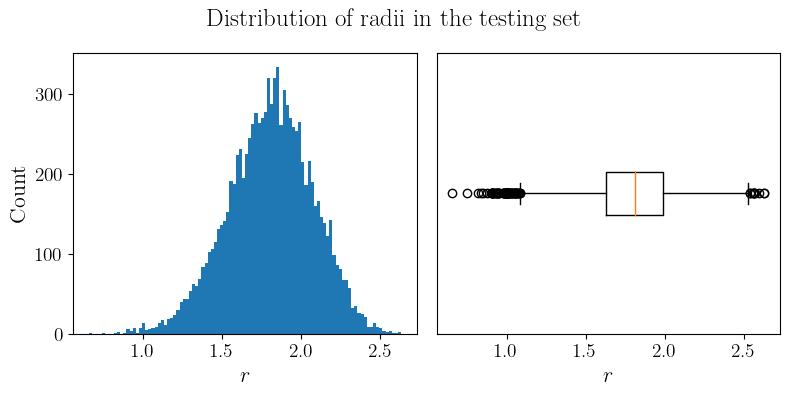

In [72]:
save = False
name = 'Figures/10D/ditribution_radii_testing.pdf'

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(rad_testing, bins=100)
axs[0].set(xlabel='$r$', ylabel='Count')

axs[1].boxplot(rad_testing, vert=False)
axs[1].set(xlabel='$r$')
axs[1].set_yticks([])
       
fig.suptitle('Distribution of radii in the testing set', size=18)
fig.tight_layout()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Load a model

In [73]:
MSE = []
MAE = []
MaAE = []

for i in range(5):
    model_name = f'Saved_models/10D/2_layer_width_study/batch_32-K_200-iter_{i}'
    model = keras.models.load_model(model_name)
    MSE.append(Helpers.MSE(model, features_test, labels_test))
    MAE.append(Helpers.MAE(model, features_test, labels_test))
    MaAE.append(Helpers.MaAE(model, features_test, labels_test))

In [81]:
# Check the min, mean, and max
a = MaAE
print(f'Min : {np.min(a):.4e}')
print(f'Mean : {np.mean(a):.4e}')
print(f'Max : {np.max(a):.4e}')

Min : 7.8892e-01
Mean : 8.4377e-01
Max : 9.0651e-01


In [75]:
best = np.argmin(MSE)
best

3

In [16]:
model_name = f'Saved_models/10D/Model_sum/K_100-depth_2'
model = keras.models.load_model(model_name)
history = pd.read_csv(model_name + '.csv')

In [17]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-05>

## Assess the performance of the model on the testing set

In [41]:
mse = Helpers.MSE(model, features_test, labels_test)
mae = Helpers.MAE(model, features_test, labels_test)
maae = Helpers.MaAE(model, features_test, labels_test)
print(f'The MSE is : {mse:.4e}')
print(f'The MAE is : {mae:.4e}')
print(f'The MaAE is : {maae:.4e}')

The MSE is : 1.2044e-07
The MAE is : 2.1132e-04
The MaAE is : 3.0220e-03


## Print the history

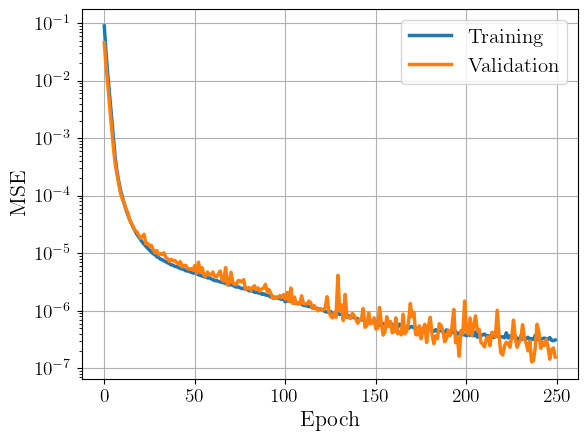

In [28]:
save = False
name = 'Figures/10D/Model_sum/best_training_error.pdf'

plt.figure()
plt.plot(history['epoch'], history['loss'])
plt.plot(history['epoch'], history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training', 'Validation'])
plt.yscale('log')
plt.grid()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Check the results against the radius

In [20]:
center = np.zeros(10)
r = np.sqrt(10)/2    
k = 50

In [26]:
x = np.linspace(-1, 1, 50000)
coord = np.tile(x, (10, 1)).T  

rad = np.linalg.norm(coord - center, ord=2, axis=1)
pred = model.predict(coord).ravel()

y_true = 1/2*(1 + np.tanh(-k*(rad - r)))

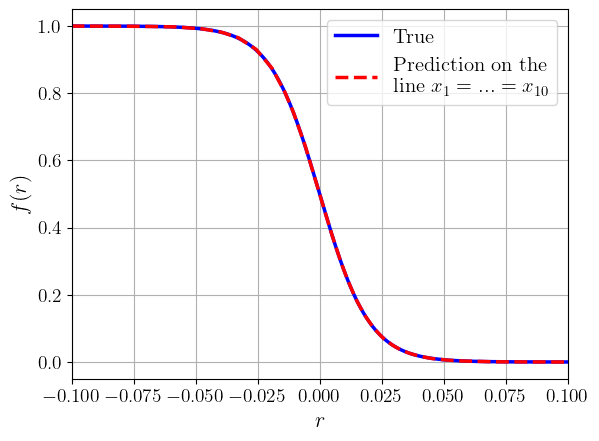

In [30]:
save = False
name = 'Figures/10D/Model_sum/best_approximation_zoom.pdf'

plt.figure()
plt.plot(rad, y_true, 'b-', label='True')
plt.plot(rad, pred, 'r--', label='Prediction on the\nline $x_1 = ... = x_{10}$')
plt.xlabel('$r$')
plt.ylabel('$f(r)$')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.grid()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Print a summary of the loaded model

In [31]:
model.sequence.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               1100      
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dense3 (Dense)               (None, 1)                 101       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________


## Extract layers and weights of the model

In [32]:
layers = [model.sequence.get_layer(name=f'dense{i}') for i in range(1,4)]

## Compute the basis functions created by the model

In [33]:
center = np.zeros(10)
#r = np.sqrt(10)/2    
r = 0
k = 50

In [35]:
x = np.linspace(-1, 1, 50000)
coord = np.tile(x, (10, 1)).T  

#rad = np.linalg.norm(coord - center, ord=2, axis=1)
rad = np.sum(coord, axis=1)/10

y_true = 1/2*(1 + np.tanh(-k*(rad - r)))

In [36]:
basis_1 = Helpers.basis_functions_radius(coord, layers[0:1])
basis_2 = Helpers.basis_functions_radius(coord, layers[0:2])

## Visualize the basis functions

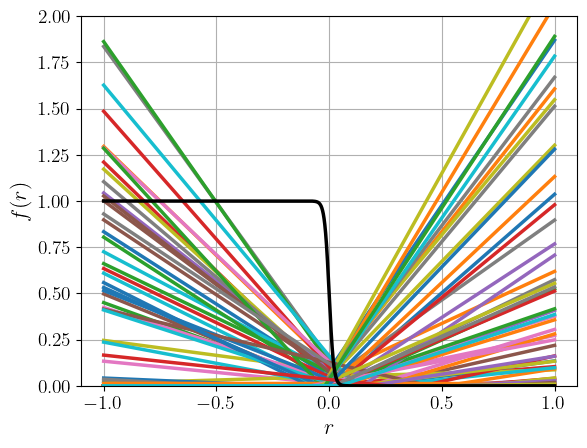

In [40]:
filename = 'Figures/10D/Model_sum/best_layer_1.pdf'
save = False

# To visualize only one function each offset values
offset = 1

# To visualize the right layer
basis = basis_1

plt.figure()
for i in range(0, len(basis), offset):
    plt.plot(rad, basis[i,:])
plt.plot(rad, y_true, 'k-')
plt.xlabel('$r$')
plt.ylabel('$f(r)$')
plt.ylim([0, 2])
plt.grid()
if (save):
    plt.savefig(filename, bbox_inches='tight')
plt.show()

In [34]:
plt.close('all')